# Correspondence of Wine Taster's Given Point and Comment In Their Reviews Using Sentiment Analysis (Hugging Face Transformers)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for simple EDA
import seaborn as sns # for plotting
from transformers import AutoTokenizer # tokenizer
from transformers import AutoModelForSequenceClassification # Sequence Classification
from scipy.special import softmax # Softmax


## Read in data

In [3]:
dataframe = pd.read_csv("./dataset/winemag-data-130k-v2.csv") #https://www.kaggle.com/datasets/zynicide/wine-reviews
dataframe = dataframe.head(500) # 130k is too big and slow for my learning purpose
dataframe.head() # a glance of our dataset

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Quick EDA

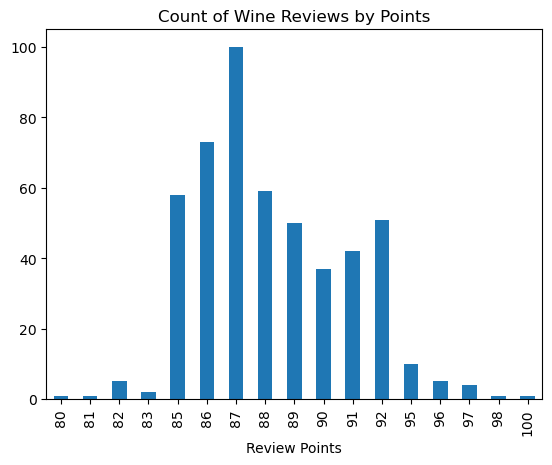

In [4]:
ax = dataframe['points'].value_counts().sort_index() \
    .plot(kind = 'bar',
          title = 'Count of Wine Reviews by Points')
ax.set_xlabel('Review Points')
plt.show()

## Getting an example

In [5]:
example = dataframe['description'][1] # get the first row for an example
print(example) # so we don't forget what our example is

This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.


## Roberta Pretrained Model

In [6]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment" # a pretrained model for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [7]:
# Run for Roberta model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy() #tensor to numpy, to store locally in array
scores = softmax(scores) #apply softmax
scores_dict = {
    'negative' : scores[0],
    'neutral' : scores[1],
    'positive' : scores[2]
}
print(scores_dict)


{'negative': 0.0039271605, 'neutral': 0.053314235, 'positive': 0.9427586}


In [8]:
#make it a function for iterration
def polarity_scores(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'negative' : scores[0],
        'neutral' : scores[1],
        'positive' : scores[2]
    }
    return scores_dict

In [9]:
# iterration to do polarity_scores for the entire dataframe
res = {} #result dict
for i, row in dataframe.iterrows():
    desc = row['description']
    myid = row['id']
    res[myid] = polarity_scores(desc) #dict index by id

In [28]:
# result of the entire dataframe polarity_scores
res

{0: {'negative': 0.08982867, 'neutral': 0.7339461, 'positive': 0.1762253},
 1: {'negative': 0.0039271605, 'neutral': 0.053314235, 'positive': 0.9427586},
 2: {'negative': 0.0080102775, 'neutral': 0.6061275, 'positive': 0.38586217},
 3: {'negative': 0.00287752, 'neutral': 0.19636476, 'positive': 0.8007577},
 4: {'negative': 0.019464169, 'neutral': 0.2584998, 'positive': 0.722036},
 5: {'negative': 0.008615631, 'neutral': 0.4848579, 'positive': 0.50652647},
 6: {'negative': 0.003338339, 'neutral': 0.4090565, 'positive': 0.5876051},
 7: {'negative': 0.008765581, 'neutral': 0.26616234, 'positive': 0.725072},
 8: {'negative': 0.0016773993, 'neutral': 0.12044009, 'positive': 0.8778825},
 9: {'negative': 0.0014241356, 'neutral': 0.035167314, 'positive': 0.9634085},
 10: {'negative': 0.0019016173, 'neutral': 0.12926817, 'positive': 0.8688302},
 11: {'negative': 0.018896688, 'neutral': 0.72501206, 'positive': 0.25609127},
 12: {'negative': 0.0061704363, 'neutral': 0.3393405, 'positive': 0.65448

In [29]:
#make a dataframe of the polarity_scores result and merge with the original dataframe
res_dataframe = pd.DataFrame(res).T
res_dataframe = res_dataframe.reset_index().rename(columns={'index': 'id'})
res_mergerd_dataframe = res_dataframe.merge(dataframe, how='left')

In [30]:
res_mergerd_dataframe 

,id,negative,neutral,positive,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,0.089829,0.733946,0.176225,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,0.003927,0.053314,0.942759,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,0.008010,0.606128,0.385862,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,0.002878,0.196365,0.800758,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,0.019464,0.258500,0.722036,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,0.001134,0.028352,0.970514,US,This El Dorado wine opens with aromas of sweet...,Battonage,87,18.0,California,El Dorado,Sierra Foothills,Virginie Boone,@vboone,Lava Cap 2010 Battonage Chardonnay (El Dorado),Chardonnay,Lava Cap
496,496,0.002118,0.051176,0.946706,Spain,"This barrel-fermented Verdejo is interesting, ...",Collection Blanco,87,25.0,Northern Spain,Rueda,NaN,Michael Schachner,@wineschach,Loess 2009 Collection Blanco Verdejo (Rueda),Verdejo,Loess
497,497,0.004960,0.381865,0.613175,US,This wine has the variety's trademark notes of...,Babcock Vineyard,87,30.0,California,Suisun Valley,North Coast,Virginie Boone,@vboone,MICA Cellars 2009 Babcock Vineyard Cabernet Fr...,Cabernet Franc,MICA Cellars
498,498,0.003725,0.146415,0.849860,US,"There are lot's of cherry, cola, sandalwood an...",Annabella,87,17.0,California,Carneros,Napa-Sonoma,NaN,NaN,Michael Pozzan 2010 Annabella Pinot Noir (Carn...,Pinot Noir,Michael Pozzan


## Plot The Result

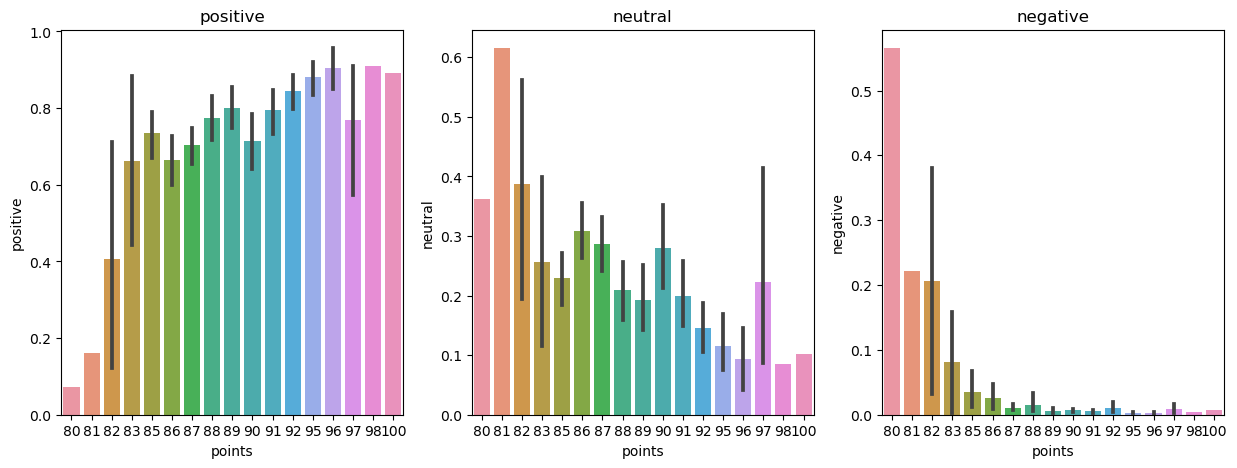

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=res_mergerd_dataframe, x= 'points', y='positive', ax=axs[0])
sns.barplot(data=res_mergerd_dataframe, x= 'points', y='neutral', ax=axs[1])
sns.barplot(data=res_mergerd_dataframe, x= 'points', y='negative', ax=axs[2])
axs[0].set_title('positive')
axs[1].set_title('neutral')
axs[2].set_title('negative')
plt.show()

# Conclusion
## Taster's given description of the wine is closely corresponds to their given points of the wine